**Introducción:**

El golpe económico de la crisis sanitaria del corona virus no va a ser cosa de semanas, sino de meses. Dentro de una de las etapas importantes posteriores a las elecciones presidenciales son la re activación de los pequeños comercios y/o centros educativos. Para ello se plantea realizar  un modelo de simulación de eventos discretos que permita determinar cual son los principales factores para la re activación económica en el ingreso a las aulas de los estudiantes.


# Enunciado:

- Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:
En base a los datos del siguiente link https://educacion.gob.ec/wp-content/uploads/downloads/2012/08/AZUAY11.pdf, genere una simulación del ingreso de los estudiantes, para ello debemos escoger un establecimiento y en base a los docentes y estudiantes modelar el reingreso de los estudiantes en base a los siguientes datos.
    - Solo se va a tener en cuanta uno de los planteles educativos(Escuela, colegio, universidad dentro del Azuay).
    - Se tiene un promedio que el 90% de los docentes han sido vacunados y pueden realizar el proceso de ingreso en cada uno de los cursos.
    - Dentro del proceso se tiene que alrededor del 5% - 10% de los estudiantes no podrán asistir debido a que no presentan la vacuna/enfermedades.
    - Los estudiantes solo pertenecen a una sola entidad educativa al igual que los docentes.
    - Se va  a tener un periodo de prueba de un mes, posterior a ello se realiza al azar al 10% de estudiantes una prueba PCR para validar que no estén contagiados.
    - De la ultima el 2% de los estudiantes dan positivo por lo que se cierra el curso completo.
    - Los estudiantes asisten cada semana y estos están en un horario de 6 horas ya sea diurno o nocturno.
    - Tienen un receso 30 minutos dentro del establecimiento en donde se concentran todos los estudiantes y es un foco de contagio del 2%.
    - El proceso de simulación desarrollado deberá considerar los siguientes aspectos:
        - Generar un cuaderno de Python para el desarrollo y parametrización de graficas, reportes, y animación (Simpy).
        - Generar una animación en 2D/3D del modelo propuesto.
        - Obtener los siguientes análisis:
            - Cuantos contagiados tengo al final del mes.
            - Cuantos cursos debo cerrar.
            - Cuantos estudiantes y docentes ingresan y salen al final del mes.
            - Opinión
            - Conclusiones
            - Recomendaciones.


# Datos
- Institucion: Colegio Tecnico Salesiano
- Numero docentes: 127
- Numero alumnos: 1823

# Resolucion del enunciado

## Parametros

In [100]:
import simpy
import random
import matplotlib.pyplot as pp
import math
import pandas as pd
import numpy as np

# Numero de docentes
NUM_DOCENTES = 127

# Numero de cursos
NUM_CURSOS = 35

# Numero de docentes vacunados (90%) del numero de docentes
NUM_DOCENTES_VACUNADOS = int((NUM_DOCENTES*90)/100)

# Numero de estudiantes
NUM_ESTUDIANTES = 1823

# Numero estudiantes vacunados (7% de los alumnos no asistiran)
NUM_ESTUDIANTES_VACUNADOS = int(NUM_ESTUDIANTES-(NUM_ESTUDIANTES*7)/100)+1

# Numero estudiantes al azar para prueba PCR (10%)
NUM_ESTUDIANTES_PCR = int((NUM_ESTUDIANTES_VACUNADOS*10)/100)

# Numero horas de clase (minutos)
NUM_HORAS_CLASE = 360

# Tiempo dentro de las aulas (minutos)
TIEMPO_AULAS = 165

# Tiempo de receso (minutos)
TIEMPO_RECESO = 30

# Porcentaje de contagio en el receso (2%)
FOCO_CONTAGIO_RECESO = int((NUM_ESTUDIANTES_VACUNADOS*2)/100)+1

# Tiempo periodo de prueba de un mes (minutos)
TIEMPO_SIMULACION = 40000#43200

# Intervalo de tiempo en que llegan las personas (minutos)
INTERVALO_LLEGADA = 5

# Lista para almacenar los estudiantes contagiados en clases 
contagiados = []

# Lista para almacenar los id de los cursos de los estudiantes contagiados 
id_contagiados = []

# Lista para almacenar los estudiantes contagiados luego de la prueba PCR
contagiados_pcr = []

# Lista para almacenar los estudiantes no contagiados luego de la prueba PCR
no_contagiados_pcr = []

# Lista para almacenar el numero de cursos que se cierran
cursos_cerrados = []

# Asignamos a cada estudiante un curso
estudiantes_cursos = {}
for i in range(NUM_ESTUDIANTES_VACUNADOS):
    estudiantes_cursos[i+1] = i+1,random.randint(1,40)
    
# Diccionario para almacenar los estudiantes escogidos para la prueba PCR (10%)
estudiantes_prueba_pcr = {}

# Lista en donde tendremos todos los estudiantes contagiados o no contagiados dentro de clases
num_estudiantes = {}
for i in range(NUM_ESTUDIANTES_VACUNADOS):
    num_estudiantes[i+1]="NoContagiado",i+1

In [101]:
# Funcion en donde se contagian los estudiantes durante el receso
def receso(env):
    yield env.timeout(TIEMPO_RECESO)
    numero_contagiados=0
    if(len(contagiados)<=FOCO_CONTAGIO_RECESO):
        # Recorremos todos los estudiantes para contagiar a una aleatoriamente
        for i in range(len(num_estudiantes.keys())):
            if(numero_contagiados<2):
                # Verificamos que aun no se haya contagiado
                if(num_estudiantes[i+1][0]=="NoContagiado"):
                    # Si se cumple la condicion contagiamos a uno aleatoriamente
                    if((random.randint(1,1000))==5):
                        # Aumentamos el numero estudiantes contagiados
                        # Y guardamos el id del estudiante contagiado
                        id=num_estudiantes[i+1][1]
                        numero_contagiados+=1
                        contagiados.append(numero_contagiados)
                        id_contagiados.append(id)
                        
    print('😷 Durante el receso se han contagiado %s' % (numero_contagiados)) 
                    
def entrar_aula(env):
    yield env.timeout(TIEMPO_AULAS)
    
        
# Funcion en donde luego del periodo de prueba se toma al 10%
# de los estudiantes no contagiados en clases, de los cuales
# el 2% dan positivo
def prueba_pcr(env):
    yield env.timeout(30)
    
    # Diccionario para guardar los estudiantes no contagiados en clases
    no_contagiados={}
    k=0
    # Tomamos los estudiantes que no se contagiaron en clases
    for i in range(len(num_estudiantes.keys())):
        if(num_estudiantes[i+1][0]=="NoContagiado"):
            k+=1
            no_contagiados[k]=num_estudiantes[i+1]
    
    k=0
    # De estos tomo el 10% al azar para realizarles la prueb PCR
    for i in range(int(len(no_contagiados.keys()))):
        if(int(len(estudiantes_prueba_pcr.keys()))<=int(len(no_contagiados.keys())*10)/100):
            if((random.randint(1,10))==5):
                k+=1
                estudiantes_prueba_pcr[k]=no_contagiados[i+1]

    # Calculamos el foco de contagio (2%) estudiantes tomados
    foco_contagio_pcr=int((len(estudiantes_prueba_pcr.keys())*2)/100)
    # Realizamos el proceso de prueba PCR
    numero_contagiados=0
    for i in range(len(estudiantes_prueba_pcr.keys())):
        if(len(contagiados_pcr)<foco_contagio_pcr):
            if((random.randint(1,10))==5):
                # Aumentamos el numero estudiantes contagiados en la PCR
                # Y guardamos el id del estudiante contagiado
                id=estudiantes_prueba_pcr[i+1][1]
                id_contagiados.append(id)
                numero_contagiados+=1
                contagiados_pcr.append(numero_contagiados)
       
    
def entrada_clases(env):
    print('**Llegan a clases %s estudiantes de los %s que se matricularon**' % (NUM_ESTUDIANTES_VACUNADOS, NUM_ESTUDIANTES))  
    print('')
    for i in range(30):
        print('--------------------------- DIA ',i+1,' ---------------------------')
        print('👉🏽 Llegan los estudiantes y proceden a entrar a sus aulas')  
        yield env.process(entrar_aula(env))

        print('👈🏽 Los estudiantes salen al receso')  
        yield env.process(receso(env))
        #Indicamos que los estudiantes han ingresado a sus aulas
        print('👉🏽 Los estudiantes entran nuevamente a sus aulas')  
        yield env.process(entrar_aula(env))
        
    # ---------------------- Empieza proceso de pruebas PCR ----------------------
    print('🦠 Termino el periodo de prueba, los estudiantes se realizan las pruebas PCR')  
    yield env.process(prueba_pcr(env))
            
                   
        

In [102]:
print('Colegio Tecnico Salesiano')
print('')

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(entrada_clases(env))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

# Calculamos ciertas metricas a mostrar en base a las listas y diccionarios creados anteriormente
num_estudiantes_pcr=int(len(estudiantes_prueba_pcr.keys()))
no_contagiados=int(len(num_estudiantes.keys()))-len(contagiados)
total_no_cotagiados=NUM_ESTUDIANTES_VACUNADOS-(len(contagiados)+(len(contagiados_pcr)))

# Añadimos los cursos que deben cerrarse en base a los estudiantes contagiados (id_contagiados)
# Recorriendo el id de los contagiados y comparandolos dentro del diccionario de alumnos, en donde
# se tiene el curso por id de estudiante
for i in range(len(id_contagiados)):
    for j in range(int(len(estudiantes_cursos.keys()))):
        if(estudiantes_cursos[j+1][0]==id_contagiados[i]):
            cursos_cerrados.append(estudiantes_cursos[j+1][1])
            
# Eliminamos los repetidos
cursos_cerrados = list(dict.fromkeys(cursos_cerrados))
       
# Mostramos los resultados
print('')
print('-------------------------------------------------------------')
print('Numero de estudiantes Contagiados en clases: ',len(contagiados))
print('-------------------------------------------------------------')
print('Numero de estudiantes No contagiados en clases: ',no_contagiados)
print('-------------------------------------------------------------------------------------')
print('Numero de estudiantes que entraron a las pruebas PCR (10% no contagiados): ',num_estudiantes_pcr)
print('-------------------------------------------------------------')
print('Numero de estudiantes positivos en las pruebas PCR: ',len(contagiados_pcr))
print('-------------------------------------------------------------')
print('Numero de estudiantes negativos en las pruebas PCR: ',num_estudiantes_pcr-len(contagiados_pcr))
print('-------------------------------------------------------------')
print('Numero de estudiantes totales Contagiados: ',len(contagiados)+(len(contagiados_pcr)))
print('--------------------------------------------------------------')
print('Numero de estudiantes totales No contagiados: ',total_no_cotagiados)
print('--------------------------------------------------------------')
print('Cursos a cerrar: ',cursos_cerrados)
print('--------------------------------------------------------------')
print('Total cursos a cerrar: ',len(cursos_cerrados))
print('--------------------------------------------------------------')
print('Id de los estudiantes contagiados: ',id_contagiados)

Colegio Tecnico Salesiano

**Llegan a clases 1696 estudiantes de los 1823 que se matricularon**

--------------------------- DIA  1  ---------------------------
👉🏽 Llegan los estudiantes y proceden a entrar a sus aulas
👈🏽 Los estudiantes salen al receso
😷 Durante el receso se han contagiado 2
👉🏽 Los estudiantes entran nuevamente a sus aulas
--------------------------- DIA  2  ---------------------------
👉🏽 Llegan los estudiantes y proceden a entrar a sus aulas
👈🏽 Los estudiantes salen al receso
😷 Durante el receso se han contagiado 2
👉🏽 Los estudiantes entran nuevamente a sus aulas
--------------------------- DIA  3  ---------------------------
👉🏽 Llegan los estudiantes y proceden a entrar a sus aulas
👈🏽 Los estudiantes salen al receso
😷 Durante el receso se han contagiado 1
👉🏽 Los estudiantes entran nuevamente a sus aulas
--------------------------- DIA  4  ---------------------------
👉🏽 Llegan los estudiantes y proceden a entrar a sus aulas
👈🏽 Los estudiantes salen al receso
😷 Durant

## Generacion de graficas

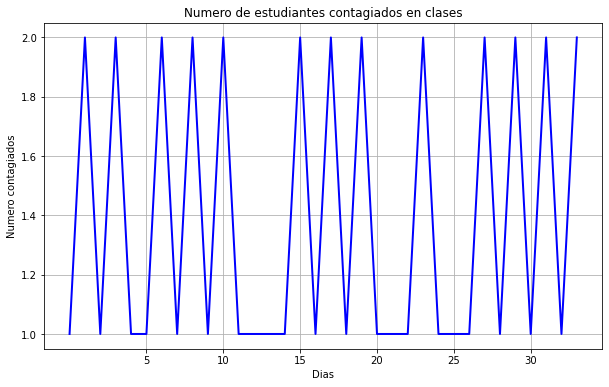

In [104]:
# Generamos la grafica del tiempo de espera
datos=contagiados # Ordenamos los datos
pp.figure(figsize=(10,6))
pp.xticks([5,10,15,20,25,30])
pp.plot(datos,linewidth=2,color='blue') #Dibujamos las lineas
pp.xlabel('Dias')
pp.ylabel('Numero contagiados')
pp.title("Numero de estudiantes contagiados en clases")
pp.grid(True) #Generamos una cuadricula
pp.show()

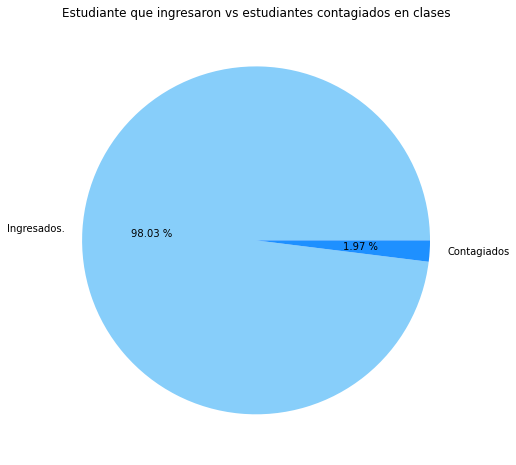

In [105]:
pp.figure(figsize=(8,8))
etiquetas = ['Ingresados.', 'Contagiados']
colores = ['lightskyblue', 'dodgerblue']
pp.pie([NUM_ESTUDIANTES_VACUNADOS, len(contagiados)], labels=etiquetas, colors=colores, autopct='%.2f %%')
pp.title('Estudiante que ingresaron vs estudiantes contagiados en clases')
pp.show()

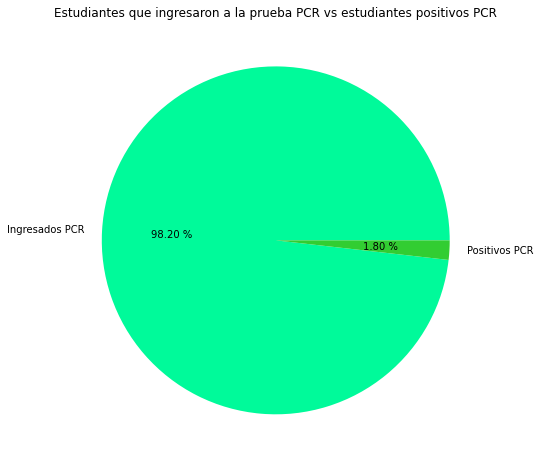

In [106]:
pp.figure(figsize=(8,8))
etiquetas = ['Ingresados PCR', 'Positivos PCR']
colores = ['mediumspringgreen','limegreen']
pp.pie([num_estudiantes_pcr, len(contagiados_pcr)], labels=etiquetas, colors=colores, autopct='%.2f %%')
pp.title('Estudiantes que ingresaron a la prueba PCR vs estudiantes positivos PCR')
pp.show()

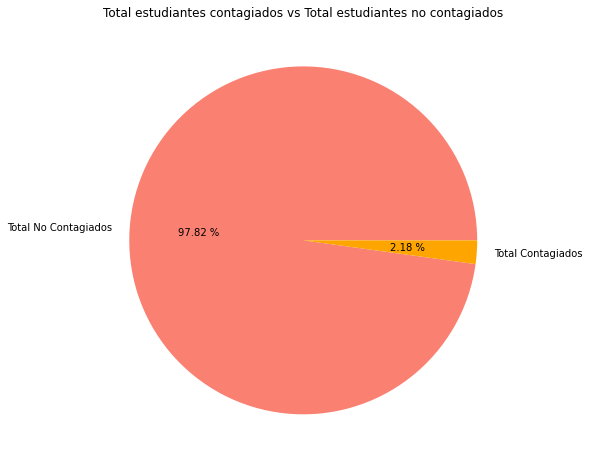

In [107]:
num_estudiantes_pcr=int(len(estudiantes_prueba_pcr.keys()))

pp.figure(figsize=(8,8))
etiquetas = ['Total No Contagiados', 'Total Contagiados']
colores = ['salmon','orange']
pp.pie([total_no_cotagiados, (len(contagiados)+len(contagiados_pcr))], labels=etiquetas, colors=colores, autopct='%.2f %%')
pp.title('Total estudiantes contagiados vs Total estudiantes no contagiados')
pp.show()

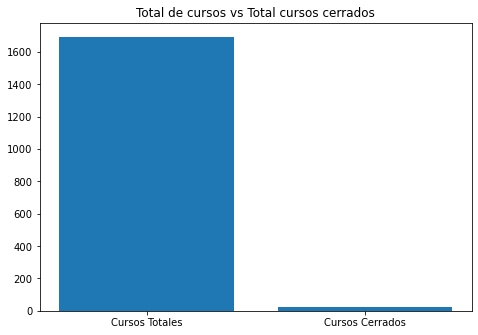

In [145]:
fig = pp.figure()
ax = fig.add_axes([1,1,1,1])
langs = ['Cursos Totales', 'Cursos Cerrados']
cursos = [len(estudiantes_cursos.keys()),len(cursos_cerrados)]
pp.title('Total de cursos vs Total cursos cerrados')
ax.bar(langs,cursos)
pp.show()